Here we are basicly replicating my [Human Protein Atlas coexpression](https://github.com/TomConlin/human_protein_atlas_coexpression) notebook but with BGEE expression data

In [185]:
import csv
import re
#import array
import numpy as np
import matplotlib.pyplot as plt
import statistics
import requests
import json
import yaml
import re
import os
import networkx as nx
import datetime
import operator

In [2]:

# reduce ordered catagories to numbers 
levels = {
    'absent' : -1,
    'present': 1
}

reliabilities = {
    'gold quality' : 2,
    'silver quality' : 1,
    'bronze quality' : 0
}

Nomenclature maintaince has to happen somewhere  
Either early or late.  
Although Ensembl is very lilely to be current     
Monarch tends to standardise on NCBIGene IDs for other things 

[HGNC API doc](https://www.genenames.org/help/rest-web-service-help)  
and  
[Bulk Download](https://www.genenames.org/cgi-bin/download)

in this process, the time to convert ids and symbols is after
the set of tissue is associated with a gene  
b/w then it is once per profile, instead of per measurement.

In [33]:
# https://www.genenames.org/cgi-bin/download?
# col=gd_app_sym
# col=gd_pub_eg_id
# col=gd_pub_ensembl_id
# col=md_eg_id&
# col=md_ensembl_id
# status=Approved
# status_opt=2
# order_by=gd_pub_eg_id
# format=text
# submit=submit

HGNCURL='http://www.genenames.org/cgi-bin/download?'

query = "&".join([
    'col=gd_pub_ensembl_id',
    'col=md_ensembl_id',
    'col=gd_pub_eg_id',
    'col=md_eg_id',
    'col=gd_app_sym',
    'order_by=gd_pub_ensembl_id',
    'status=Approved',
    'status_opt=2',
    'format=text',
    'submit=submit'
])

In [34]:
response = requests.get(HGNCURL + query)

In [35]:
if response.status_code == requests.codes.ok:
    hgnc = response.text.splitlines()
    hgnc.pop(0)  # header
else: 
    print('ERROR ' + response.url + ' returned '+ str(response.status_code))

In [268]:
ensg_sym = {}  # in case there are any not mapped to ncbi as well
sym_ensg = {}
ensg_ncbi = {}
ncbi_sym = {}

sym_ncbi = {}

for line in hgnc:
    (ens1, ens2, eg1, eg2, symbol) = re.split(r'\t',line)
    ensg = ens2 if ens1 == '' else ens1
    ncbi = eg2 if eg1 == '' else eg1    
    if ensg != '': 
        if symbol != '':
            ensg_sym[ensg] = symbol
            sym_ensg[symbol] = ensg # to search network for our FA genes
        if ncbi != '':
            ensg_ncbi[ensg] = ncbi
    if ncbi != '':
        ncbi_sym[ncbi] = symbol
        sym_ncbi[symbol] = ncbi

In [44]:
len(ensg_sym)

36863

In [49]:
len(ncbi_sym) 

41139

In [46]:
len(ensg_ncbi)

36841

As feared thare are tens of thousands of these measurements won't map directly back to something we can integreate, but it is still important to process them all because if something comes up as interesting, one could at least go back to the underlying sequence.  

note: we can (should) never get an empty gene symbol from the nomenclature athority

as there are slightly more ensembl->symbol than ensembl->ncbi  
 - first try ensembl->symbol   
 - then ensembl->ncbi->symbol 

In [59]:
with open('ensgid_symbol_hgnc.yaml', 'w') as fh:
    yaml.dump(ensg_sym, fh)
with open('ncbi_symbol_hgnc.yaml', 'w') as fh:
    yaml.dump(ncbi_sym, fh)    
with open('ensg_ncbi.yaml', 'w') as fh:
    yaml.dump(ensg_ncbi, fh) 

Use the tissue measurement frequency to set the order for tissue profile recording

In [70]:
file = 'tissue_count.tab' 
# count tissue_id
tissue_index = {}
with open(file, newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter='\t')
    #csvreader.__next__()  # header
    line_number = 0
    for line in csvreader:
        (count, tissue_id) = line
        tissue_index[tissue_id] = line_number
        line_number += 1
tissue_length = len(tissue_index)        

In [88]:
file = 'Homo_sapiens_expr_simple.tsv'
#1:Gene ID
#2:"Gene name"
#3:Anatomical entity ID
#4:"Anatomical entity name"
#5:Expression
#6:Call quality
#7:Expression rank

# make places to stash stuff 
gene_tissue = {}
#gene_tissue_rank_curve = {}
tissue_names = {}
gene_names = {}

with open(file, newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter='\t', quotechar='"')
    csvreader.__next__()  # header
    for line in csvreader:
        # print(line)
        (gene_id, gene_name, tissue_id, tissue_name, level, reliability, rank) = line
        
        # record the measurement   
        if gene_id in gene_tissue:
            gene_tissue[gene_id][tissue_index[tissue_id]] = levels[level]
        else:
            gene_tissue[gene_id] = np.array([0] * tissue_length)
            gene_tissue[gene_id][tissue_index[tissue_id]] = levels[level]

        # save human friendly tissue label 
        if tissue_id not in tissue_names:
            tissue_names[tissue_id] = tissue_name
        
        # save human friendly gene symbol 
        if gene_id not in gene_names:
            gene_names[gene_id] = gene_name

In [73]:
# update gene symbols
for gene_id in gene_tissue:
      # try to bring gene info up to date
        if gene_id in ensg_sym and gene_name != gene_names[gene_id]:
            print('NOTE: '+ ensg_sym[gene_id]+ ' is replacing ' + gene_names[gene_id] + ' b/c ' + gene_id)
            gene_names[gene_id] = ensg_sym[gene_id]
        elif gene_id in ensg_ncbi and ensg_ncbi[gene_id] in ncbi_sym \
                and  gene_names[gene_id] != ncbi_sym[ensg_ncbi[gene_id]]:
            print('NOTE: '+ ncbi_sym[ensg_ncbi[gene_id]] + ' is replacing ' + gene_name + ' b/c ' + gene_id + ' -> ' + ensg_ncbi[gene_id])
            gene_names[gene_id] = ncbi_sym[ensg_ncbi[gene_id]]


In [80]:
len(gene_tissue)

59171

In [91]:
sum(gene_tissue['ENSG00000002330'] * gene_tissue['ENSG00000003402'])

188

In [90]:
np.dot(gene_tissue['ENSG00000002330'], gene_tissue['ENSG00000003402'])

188

In [97]:
np.dot(gene_tissue['ENSG00000002330'], gene_tissue['ENSG00000003402'])/min(np.count_nonzero(gene_tissue['ENSG00000002330']),np.count_nonzero(gene_tissue['ENSG00000003402']))

0.73151750972762641

With this relative scoring scheme I am trying to normalize based only the reported measures
that is; an unreported measurement is not counted as penalty alowing more "perfect matches"  

however since this normalization is unique for each pair of genes  
it means comparing scores between different pairs is not as meaningful.


In [98]:
np.dot(gene_tissue['ENSG00000002330'], gene_tissue['ENSG00000003402'])/len(gene_tissue['ENSG00000003402'])

0.60256410256410253

this "absolute" normalizing does allow different pairs to be compared, but I expect vanishingly few will top out even if they agree on all available points.

Probably keep both, and use the relative score to surface interesting associations 
and the absolute to give people something they can compare. 

  !# Try to find NCBIGene_id for Ensenbl_ID
        # try to convert ids from ensembl to ncbi 
        gene_id = ensg_ncbi[gene_id] if gene_id in ensg_ncbi else gene_id

        !# last gasp conversion based on gene symbol
        if gene_id == ensg and gene_name in sym_ncbi:
            # print('WARN: ' + sym_ncbi[gene_name] + ' is replacing '+ ensg + ' b/c '+ gene_name)
            gene_id = sym_ncbi[gene_name]

In [101]:
# save a copy 
#with open('gene_tissue_curve.yaml', 'w') as fh:
#    yaml.dump(gene_tissue, fh)
# Ack! can't dump numpy arrays like this they are binary   

# gene_tissue.savetext('gene_tissue_curve.txt')
# nor like that because the container is not numpy 

In [108]:
genes = list(gene_tissue) # need a fixed order
genlen = len(genes)
gtlen = len(gene_tissue[genes[1]])
genes[1]

# note: thanks to the opaqueness of the datastructures 
# we have no idea how we are hopping around in memory
# while marching straight down this list.

'ENSG00000133055'

((59172^2)/2)-59172 == 1,750,603,620

1.75  billion comparisons involving pairs vectors with 300 values each

maybe I should switch to Julia for this next part.

#### Take 2
In retrospect (looking at first run which tooks about 2.5 hours),   
keeping only those for which there is no reported disagreement 
subjectivly results in too many edges. 
So the relative score is a constant 'one'
and the absolute score is more directly expressed as 
how many concordant mesurements or since we are only taking consensus results
how many tissues did this pair of genes up|down express in the same direction?

there is also a slight difference in how zeros are counted  
first run 'unreporteds' were counted for each gene-tissue-set insependently
then the one with the most zeros determined the relative limit.

For this second run I combine the vectors before counting zeros.
since this could result in fewer zeros than the min of the components
there is a risk of generating even more edges.  
will revert if it is a problem.

In [269]:
rel_scores={}
print(str(datetime.datetime.now()))
for a in range(1,genlen-1):
    a_name = genes[a]
    if 0==a%1000:
        print(str(a) + ' kept ' + str(len(rel_scores)) +  " " + str(datetime.datetime.now()))      
    for b in range(a+1, genlen):
        product = gene_tissue[a_name] * gene_tissue[genes[b]]
        commom =  np.count_nonzero(product)
        # limit output
        if common == sum(product) :
            rel_scores[a_name + ',' + genes[b]] = common

print(str(genlen) + ' kept ' + str(len(rel_scores)) +  " " + str(datetime.datetime.now()))

2017-10-06 12:21:54.202561


NameError: name 'common' is not defined

In [142]:
len(rel_scores)/len(genes)


245.03954639941864

In [149]:
associated = list(rel_scores.keys())

In [147]:
with open('bgee_coexp_network.yaml', 'w') as fh:
    yaml.dump(associated, fh)

In [153]:
list(associated[1].split(','))

['ENSG00000124172', 'ENSG00000265638']

In [266]:
G = nx.Graph()
for edge in associated:
    ee=edge.split(',')
    G.add_edge(ee[0],ee[1])

In [157]:
print(nx.number_connected_components(G))

217


__WOW__ exatctly one fewer cluster than the Human Protein Atlas notenook.


In [159]:
clusters = nx.connected_components(G)

In [164]:
c = next(clusters)

In [169]:
for e in c:
    if e in ensg_sym:
        print(ensg_sym[e])
    else: 
        print(e)

OR9I1
OR10G9
OR8D4
RNU6-974P
OR10N1P
OR10G6
OR10G4
ENSG00000267478
OR4K8P
TRIM60P5Y
MRPS35P3
OR4D5
ENSG00000255065
ENSG00000250503
ENSG00000279666
ENSG00000256041
ENSG00000259507


In [172]:
G.neighbors('ENSG00000255065')

['ENSG00000172377',
 'ENSG00000198674',
 'ENSG00000236981',
 'ENSG00000224210',
 'ENSG00000181518',
 'ENSG00000206826',
 'ENSG00000213181',
 'ENSG00000254737',
 'ENSG00000267478',
 'ENSG00000266693',
 'ENSG00000270192',
 'ENSG00000171014',
 'ENSG00000250503',
 'ENSG00000279666',
 'ENSG00000256041',
 'ENSG00000259507']

In [191]:
#nx.average_degree_connectivity(G)

In [192]:
#nx.average_neighbor_degree(G)

keeping only those edges between genes (ENSMBLs)  
for which there is no contrary evidence of co-expression  
results in an awful lot of edges.  

it may be help clarity to filter genes that are ubiquoisly co expressed

In [189]:
degree_sequence = sorted(G.degree().items(), key=operator.itemgetter(1),  reverse=True)
# sorted(x.items(), key=operator.itemgetter(1))

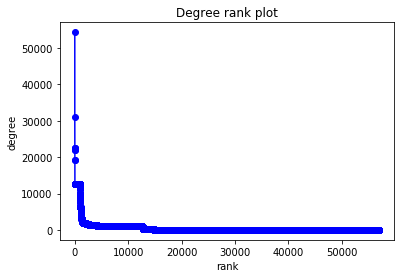

In [212]:
# adapted from: 
# https://networkx.github.io/documentation/stable/auto_examples/drawing/plot_degree_rank.html#sphx-glr-auto-examples-drawing-plot-degree-rank-py
plt.plot([d for n,d in degree_sequence], 'b-', marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")
plt.show()

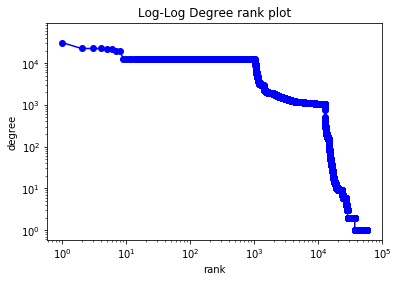

In [240]:
plt.loglog([d for n,d in degree_sequence], 'b-', marker='o')
plt.title("Log-Log Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")
plt.show()

That looks like the first ten are outregous   
then the first thousands (the flat line) very suspect

Setting a threshold on degree at 1,000 

I wonder if the piece wise nature of the curve reflects 
different dataset policy and procdures  




In [225]:
#
with open('bgee_rank_degree.txt', 'w') as fh:
    fh.write(str([d for n,d in degree_sequence]))

In [252]:
# ! tr ',' '\n' < bgee_rank_degree.txt  | tr -d "] ["  | head -200 | grep -n .
# G.nodes()[2].rank()
# G.degree().items()

In [261]:
k=0
for n, r in  G.degree().items(): 
    if r > 1000:
        k+=1
        print(str(k) + ": removing " + n + " with " + str(r)  + " edges") 
        G.remove_node(n)

1: removing ENSG00000197989 with 1944 edges
2: removing ENSG00000231663 with 1752 edges
3: removing ENSG00000198561 with 1001 edges
4: removing ENSG00000164983 with 2329 edges
5: removing ENSG00000187736 with 1182 edges
6: removing ENSG00000052795 with 1957 edges
7: removing ENSG00000279089 with 4923 edges
8: removing ENSG00000117481 with 2225 edges
9: removing ENSG00000164713 with 1957 edges
10: removing ENSG00000154710 with 2154 edges
11: removing ENSG00000115306 with 1201 edges
12: removing ENSG00000173011 with 1002 edges
13: removing ENSG00000160766 with 2766 edges
14: removing ENSG00000169045 with 1056 edges
15: removing ENSG00000063046 with 1050 edges
16: removing ENSG00000169021 with 2234 edges
17: removing ENSG00000144455 with 1107 edges
18: removing ENSG00000198856 with 2164 edges
19: removing ENSG00000101421 with 1957 edges
20: removing ENSG00000204954 with 2185 edges
21: removing ENSG00000180992 with 2336 edges
22: removing ENSG00000180822 with 1204 edges
23: removing ENSG00

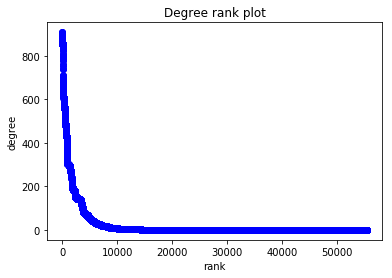

In [265]:
plt.plot([d for n,d in sorted(G.degree().items(), key=operator.itemgetter(1),  reverse=True)], 'b-', marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")
plt.show()